In [14]:
pip install langgraph langchain-core

In [18]:
# --- 1. INSTALLATION (Run this once if needed) ---
# !pip install -q langgraph langchain-core requests

# --- 2. IMPORTS ---
import os
import json
import time
import requests
import operator
from typing import Annotated, Sequence, TypedDict, Literal
from google.colab import userdata

from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# --- 3. CONFIGURATION ---
OPENROUTER_API_URL = "https://openrouter.ai/api/v1/chat/completions"
OPENROUTER_MODEL = "mistralai/devstral-2512:free"  # or "mistralai/mistral-7b-instruct"

# Retrieve Key safely
try:
    OPENROUTER_API_KEY = userdata.get('OPENROUTER_API_KEY')
except Exception:
    OPENROUTER_API_KEY = input("Enter your OpenRouter API Key: ")

# --- 4. CUSTOM API HELPER ---
def call_openrouter(messages: list, system_prompt: str):
    """
    Sends the conversation history to OpenRouter using standard requests.
    """
    formatted_messages = [{"role": "system", "content": system_prompt}]

    # format messages for the API
    for msg in messages:
        if isinstance(msg, HumanMessage):
            formatted_messages.append({"role": "user", "content": msg.content})
        elif isinstance(msg, AIMessage):
            formatted_messages.append({"role": "assistant", "content": msg.content})
        elif isinstance(msg, dict):
            formatted_messages.append(msg)

    payload = {
        "model": OPENROUTER_MODEL,
        "messages": formatted_messages,
        "temperature": 0.7,
        "max_tokens": 1000
    }

    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "HTTP-Referer": "https://colab.research.google.com",
        "X-Title": "LangGraph Agent",
        "Content-Type": "application/json"
    }

    try:
        # Timeout set to 20s to prevent hanging
        response = requests.post(OPENROUTER_API_URL, headers=headers, json=payload, timeout=20)
        response.raise_for_status()
        return response.json()["choices"][0]["message"]["content"]
    except Exception as e:
        return f"Error contacting API: {e}"

# --- 5. STATE DEFINITION ---
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next_step: str
    loop_count: int  # <--- Safety Counter

# --- 6. AGENT NODES ---

def researcher_node(state: AgentState):
    print(f"   ...Researcher is calling API...")
    messages = state["messages"]

    content = call_openrouter(
        messages,
        system_prompt="You are a Researcher. Provide 3 key facts about the user's topic."
    )
    return {"messages": [AIMessage(content=f"Researcher: {content}")]}

def writer_node(state: AgentState):
    print(f"   ...Writer is calling API...")
    messages = state["messages"]

    content = call_openrouter(
        messages,
        system_prompt="You are a Writer. Write a short paragraph based on the Researcher's facts."
    )
    return {"messages": [AIMessage(content=f"Writer: {content}")]}

# --- 7. SUPERVISOR NODE (With Safety Limit) ---

def supervisor_node(state: AgentState):
    # Increment loop counter
    current_loop = state.get("loop_count", 0) + 1

    print(f"--- 🤖 SUPERVISOR THINKING (Step {current_loop}) ---")

    # --- SAFETY BRAKE ---
    # If we have gone more than 3 steps, FORCE STOP.
    if current_loop > 3:
        print("--- 🛑 LIMIT REACHED: STOPPING NOW ---")
        return {"next_step": "FINISH", "loop_count": current_loop}

    messages = state["messages"]
    last_message = messages[-1].content if messages else ""

    # Routing Logic
    if "Researcher:" in last_message:
        next_node = "Writer"
    elif "Writer:" in last_message:
        next_node = "FINISH"
    else:
        next_node = "Researcher"

    return {"next_step": next_node, "loop_count": current_loop}

def router_logic(state: AgentState) -> Literal["Researcher", "Writer", "__end__"]:
    step = state["next_step"]
    if step == "FINISH":
        return END
    return step

# --- 8. GRAPH CONSTRUCTION ---

builder = StateGraph(AgentState)
builder.add_node("Supervisor", supervisor_node)
builder.add_node("Researcher", researcher_node)
builder.add_node("Writer", writer_node)

builder.add_edge(START, "Supervisor")
builder.add_conditional_edges("Supervisor", router_logic, {"Researcher": "Researcher", "Writer": "Writer", "__end__": END})
builder.add_edge("Researcher", "Supervisor")
builder.add_edge("Writer", "Supervisor")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# --- 9. EXECUTION ---

config = {"configurable": {"thread_id": "safe-run-final"}}
topic = "What is mlops"

print(f"🚀 Starting System with Topic: {topic}\n")

# Initialize with loop_count = 0
initial_state = {
    "messages": [HumanMessage(content=topic)],
    "next_step": "start",
    "loop_count": 0
}

# Run the graph
try:
    for event in graph.stream(initial_state, config=config):
        pass
except Exception as e:
    print(f"Execution Error: {e}")

# Print Final Result
print("\n" + "="*40)
print("FINAL OUTPUT")
print("="*40)
final_state = graph.get_state(config)
if final_state.values.get("messages"):
    print(final_state.values["messages"][-1].content)
else:
    print("No output generated.")

🚀 Starting System with Topic: What is mlops

--- 🤖 SUPERVISOR THINKING (Step 1) ---
   ...Researcher is calling API...
--- 🤖 SUPERVISOR THINKING (Step 2) ---
   ...Writer is calling API...
--- 🤖 SUPERVISOR THINKING (Step 3) ---
   ...Writer is calling API...
--- 🤖 SUPERVISOR THINKING (Step 4) ---
--- 🛑 LIMIT REACHED: STOPPING NOW ---

FINAL OUTPUT
Writer: Researcher: Here are three key facts about **MLOps** (Machine Learning Operations):

1. **Definition and Purpose**:
   MLOps is a set of practices that combines **Machine Learning (ML)**, **DevOps**, and **Data Engineering** to streamline the deployment, monitoring, and maintenance of ML models in production. Its goal is to improve collaboration between data scientists, engineers, and operations teams while ensuring reliability, scalability, and efficiency in ML workflows.

2. **Core Components**:
   MLOps encompasses several key components, including:
   - **Version Control** (for code, data, and models),
   - **Automated Pipelines**

Generating Architecture Diagram...


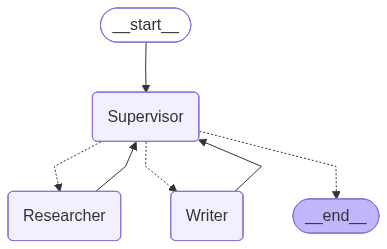

In [20]:
from IPython.display import Image, display

# 1. Generate the standard Architecture Graph
print("Generating Architecture Diagram...")
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
!pip install -q graphviz

Generated Enhanced Architecture Diagram:


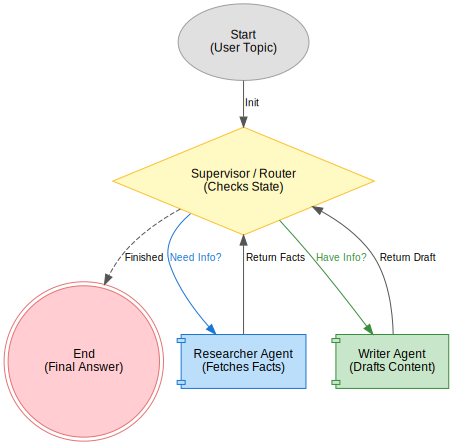

In [22]:
from graphviz import Digraph
from IPython.display import display

# Create a Directed Graph
dot = Digraph(comment='Multi-Agent Architecture')

# --- 1. GLOBAL STYLES ---
dot.attr(rankdir='TB', size='8,8')  # Top-to-Bottom layout
dot.attr('node', fontname='Arial', fontsize='12', margin='0.2')
dot.attr('edge', fontname='Arial', fontsize='10', color='#555555')

# --- 2. DEFINE NODES ---

# Start Node
dot.node('Start', 'Start\n(User Topic)',
         shape='ellipse', style='filled', fillcolor='#E0E0E0', color='#9E9E9E')

# End Node
dot.node('End', 'End\n(Final Answer)',
         shape='doublecircle', style='filled', fillcolor='#FFCDD2', color='#E57373')

# Supervisor (The Brain) - Diamond shape for "Decision"
dot.node('Supervisor', 'Supervisor / Router\n(Checks State)',
         shape='diamond', style='filled', fillcolor='#FFF9C4', color='#FBC02D', height='1.0')

# Agents - Component shape for "Workers"
dot.node('Researcher', 'Researcher Agent\n(Fetches Facts)',
         shape='component', style='filled', fillcolor='#BBDEFB', color='#1976D2')

dot.node('Writer', 'Writer Agent\n(Drafts Content)',
         shape='component', style='filled', fillcolor='#C8E6C9', color='#388E3C')

# --- 3. DEFINE EDGES (Connections) ---

dot.edge('Start', 'Supervisor', label=' Init')

# Supervisor Routing
dot.edge('Supervisor', 'Researcher', label=' Need Info?', color='#1976D2', fontcolor='#1976D2')
dot.edge('Supervisor', 'Writer', label=' Have Info?', color='#388E3C', fontcolor='#388E3C')
dot.edge('Supervisor', 'End', label=' Finished', style='dashed')

# Agents returning work
dot.edge('Researcher', 'Supervisor', label='  Return Facts')
dot.edge('Writer', 'Supervisor', label='  Return Draft')

# --- 4. RENDER ---
print("Generated Enhanced Architecture Diagram:")
display(dot)